In [1]:
import numpy as np
import corner
import matplotlib.pyplot as plt
import emcee
from scipy.stats import norm, powerlaw

Lets create the initial mass distribution of compact objects. This distribution has 6 parameters.

$p(m) \propto f \frac{1}{\sqrt{2\pi\sigma}} \exp [-\frac{(m-\mu)^2}{2\sigma^2}]+(1-f)H(m-m_{min})H(m_{max}-m) \frac{\gamma+1}{m_{max}^{\gamma+1} - m_{min}^{\gamma+1}} m^\gamma$

In [2]:
f = 0.3 # fraction of neutron stars
mu = 1.33 # mean neutron star mass
sigma = 0.2 # standard deviation of neutron star mass
m_min = 7.0 # lower bound of black hole mass range
m_max = 60.0 # upper bound of black hole mass range
gamma = -1.1 # power law index

In [3]:
def p_m(m, f, mu, sigma, m_min, m_max, gamma):
    return f * norm.pdf(m, loc=mu, scale=sigma) + np.heaviside(m-m_min,1) * np.heaviside(m_max-m,1) * (1-f) * (gamma+1) * m**gamma/(m_max**(gamma+1) - m_min**(gamma+1))

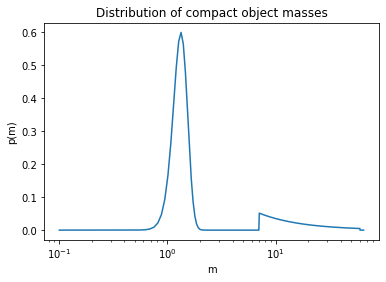

In [4]:
#Plot p(m, f, mu, sigma, m_min, m_max, gamma)
m = np.linspace(0.1, 65, 1000)
plt.semilogx(m, p_m(m, f, mu, sigma, m_min, m_max, gamma))
plt.xlabel('m')
plt.ylabel('p(m)')
plt.title('Distribution of compact object masses')
plt.show()


In [5]:
np.trapz(p_m(m, f, mu, sigma, m_min, m_max, gamma), m) # integral of p(m) to check normalization

0.9991760914185507

Now lets set up a code to sample this distribution

In [6]:
#Sample from p(m, f, mu, sigma, m_min, m_max, gamma) by emcee
def log_p(m, f, mu, sigma, m_min, m_max, gamma):
    if m < 0 or m > m_max:
        return -np.inf
    return np.log(p_m(m, f, mu, sigma, m_min, m_max, gamma)+1e-300) 

nsamples = 10000 # number of samples
nwalkers = 10 # number of walkers
ndim = 1 # number of dimensions
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_p, args=[f, mu, sigma, m_min, m_max, gamma])
p0 = np.random.rand(nwalkers, ndim)*m_max
state = sampler.run_mcmc(p0, 10000)
sampler.reset()
sampler.run_mcmc(state, nsamples,progress = True)
samples = sampler.get_chain(flat=True)


100%|██████████| 10000/10000 [00:06<00:00, 1494.32it/s]


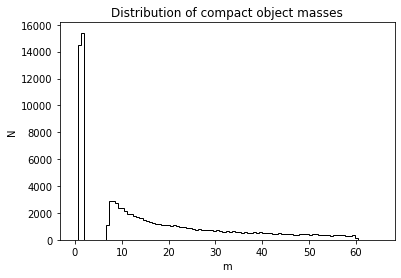

In [7]:
plt.hist(samples[:, 0], bins=np.linspace(0,65,100),  color="k", histtype="step");
plt.xlabel('m')
plt.ylabel('N')
plt.title('Distribution of compact object masses')
plt.show()

Now lets impose random pairing.

$p(m1,m2)\propto H(m1-m2)p(m1)p(m2)$

In [8]:
def log_p_m1m2(m1, m2, f, mu, sigma, m_min, m_max, gamma):
    return np.log(1e-300+np.heaviside(m1-m2,1) * p_m(m1, f, mu, sigma, m_min, m_max, gamma) * p_m(m2, f, mu, sigma, m_min, m_max, gamma))

Text(0.5, 1.0, 'Random Pairing')

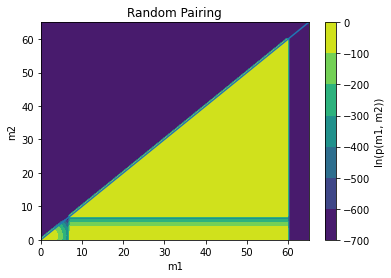

In [38]:
#Plot log_p_m1m2(m1, m2, f, mu, sigma, m_min, m_max, gamma)
l = 100
m1 = np.linspace(0.1, 65, l) * np.ones((l,l))
m2 = (np.linspace(0.1, 65, l) * np.ones((l,l))).T
plt.contourf(log_p_m1m2(m1, m2, f, mu, sigma, m_min, m_max, gamma), extent=[0,65,0,65])
plt.plot(np.linspace(0.1, 65, l),np.linspace(0.1, 65, l))
plt.xlabel('m1')
plt.ylabel('m2')
plt.colorbar(label='ln(p(m1, m2))')
plt.title('Random Pairing')

Now lets sample the distribution

In [35]:
def log_p(m, f, mu, sigma, m_min, m_max, gamma):
    if m[0] < 0 or m[0] > m_max or m[1] < 0 or m[1] > m_max:
        return -np.inf
    return log_p_m1m2(m[0], m[1], f, mu, sigma, m_min, m_max, gamma) 

nsamples = 10000 # number of samples
nwalkers = 10 # number of walkers
ndim = 2 # number of dimensions
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_p, args=[f, mu, sigma, m_min, m_max, gamma])
p0 = np.random.rand(nwalkers, ndim)*m_max
state = sampler.run_mcmc(p0, 10000)
sampler.reset()
sampler.run_mcmc(state, nsamples,progress = True)
samples = sampler.get_chain(flat=True)


100%|██████████| 10000/10000 [00:10<00:00, 980.70it/s]


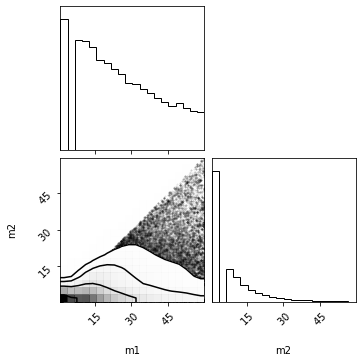

In [36]:
m1_samples, m2_samples = samples.T
 
tr=corner.corner(samples,labels=['m1','m2'],smooth=1.2,color = 'k',title_kwargs={"fontsize": 12},use_math_text=True,hist_kwargs={"density": True})
axes = np.array(tr.axes).reshape((ndim, ndim))

Text(0, 0.5, 'm2')

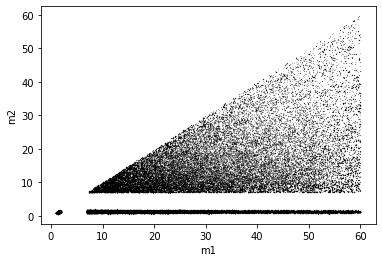

In [37]:
plt.scatter(m1_samples, m2_samples, s=.01, c='k')
plt.xlabel('m1')
plt.ylabel('m2')
plt.title('Random Pairing')

Now lets introduce a coupling function $\Pi$ 

$\Pi(q) = f_p H(q-q_1) H(q_2-q) q^{\gamma_{p1}} \frac{\gamma_{p1}+1}{q_1^{\gamma_{p1}+1} - q_2^{\gamma_{p1}+1}} + (1-f_p) H(q-q_3) H(1-q) q^{\gamma_{p2}} \frac{\gamma_{p2}+1}{1 - q_3^{\gamma_{p2}+1}}$

In [16]:
def Pi(q, fp, q1, q2, q3, gamma_p1, gamma_p2):
    return fp*np.heaviside(q-q1,1)*np.heaviside(q2-q,1)*q**gamma_p1 * (gamma_p1+1)/(q2**(gamma_p1+1) - q1**(gamma_p1+1)) + (1-fp)*np.heaviside(q-q3,1)*np.heaviside(1-q,1)*q**gamma_p2 * (gamma_p2+1)/(1 - q3**(gamma_p2+1))
def log_p_m1m2_w_q(m1, m2, f, mu, sigma, m_min, m_max, gamma, fp, q1, q2, q3, gamma_p1, gamma_p2):
    return np.log(1e-300+np.heaviside(m1-m2,1) *Pi(m2/m1, fp, q1, q2, q3, gamma_p1, gamma_p2)* p_m(m1, f, mu, sigma, m_min, m_max, gamma) * p_m(m2, f, mu, sigma, m_min, m_max, gamma))

In [17]:
fp = 0.5
q1 = 0.2
q2 = 0.3
q3 = 0.7
gamma_p1 = 0
gamma_p2 = 5



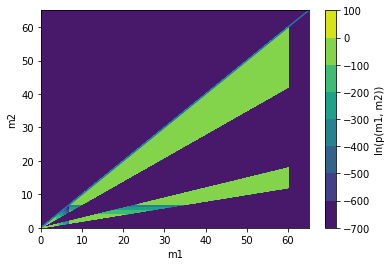

In [27]:
#Plot log_p_m1m2_w_q(m1, m2, f, mu, sigma, m_min, m_max, gamma, fp, q1, q2, q3, gamma_p1, gamma_p2)
l = 1000
m1 = np.linspace(0.1, 65, l) * np.ones((l,l))
m2 = (np.linspace(0.1, 65, l) * np.ones((l,l))).T
plt.contourf(log_p_m1m2_w_q(m1, m2, f, mu, sigma, m_min, m_max, gamma, fp, q1, q2, q3, gamma_p1, gamma_p2), extent=[0,65,0,65])
plt.plot(np.linspace(0.1, 65, l),np.linspace(0.1, 65, l))
plt.xlabel('m1')
plt.ylabel('m2')
plt.colorbar(label='ln(p(m1, m2))')

Now let's sample the distribution

In [21]:
def log_p(m, f, mu, sigma, m_min, m_max, gamma, fp, q1, q2, q3, gamma_p1, gamma_p2):
    if m[0] < 0 or m[0] > m_max or m[1] < 0 or m[1] > m_max:
        return -np.inf
    return log_p_m1m2_w_q(m[0], m[1], f, mu, sigma, m_min, m_max, gamma, fp, q1, q2, q3, gamma_p1, gamma_p2) 

nsamples = 10000 # number of samples
nwalkers = 10 # number of walkers
ndim = 2 # number of dimensions
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_p, args=[f, mu, sigma, m_min, m_max, gamma, fp, q1, q2, q3, gamma_p1, gamma_p2])
p0 = np.random.rand(nwalkers, ndim)*m_max
state = sampler.run_mcmc(p0, 10000)
sampler.reset()
sampler.run_mcmc(state, nsamples,progress = True)
samples = sampler.get_chain(flat=True)


100%|██████████| 10000/10000 [00:11<00:00, 888.78it/s]


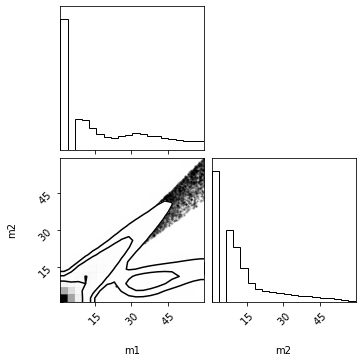

In [22]:
m1_samples, m2_samples = samples.T
 
tr=corner.corner(samples,labels=['m1','m2'],smooth=1.2,color = 'k',title_kwargs={"fontsize": 12},use_math_text=True,hist_kwargs={"density": True})
axes = np.array(tr.axes).reshape((ndim, ndim))

Text(0, 0.5, 'm2')

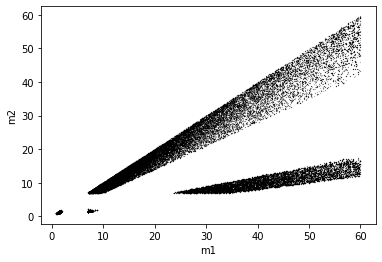

In [31]:
plt.scatter(m1_samples, m2_samples, s=.01, c='k')
plt.xlabel('m1')
plt.ylabel('m2')

Text(0.5, 0, 'q')

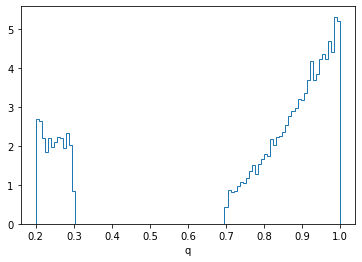

In [34]:
plt.hist(m2_samples/m1_samples, bins=100, density=True, histtype='step');
plt.xlabel('q')